In [1]:
!cd /media/veec20/Data/duongdq/CNN/gameofdeeplearning/
!ls

 balance_data.ipynb	    data	'preprocess data.ipynb'   weight
 build_efficientnet.ipynb   effnet.png	 pytorch.ipynb
 connect.ipynb		    model.png	 split
 csv			    preprocess	 submission.csv


In [2]:
# import lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import cv2
import time
import shutil
import random as rn
from PIL import Image
from functools import partial
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import class_weight

# Repository source: https://github.com/qubvel/efficientnet
sys.path.append(os.path.abspath('/media/veec20/Data/duongdq/CNN/efficientnet/efficientnet_qubvel/'))
import efficientnet.keras
from efficientnet.keras import EfficientNetB5

import tensorflow as tf
from keras import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.optimizers import Adam
from keras.engine import Layer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


# path specification

In [3]:
# path specification
train_df_path = './data/246/246_train_data.csv'
valid_df_path = './data/246/246_validation_data.csv'
test_df_path = './csv/test.csv'

train_image_path = './preprocess/246_padding/'
valid_image_path = './preprocess/246_padding/'
test_image_path = './data/data_raw/origin/test/'

# specify title of our final model
SAVED_MODEL_NAME = '37_efficient_model.h5'

# Set seed for reproducability
seed = 1234
rn.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# For keeping time. GPU limit for this competition is set to ± 9 hours.
t_start = time.time()

In [4]:
train_df = pd.read_csv(train_df_path)
valid_df = pd.read_csv(valid_df_path)
test_df = pd.read_csv('./csv/test.csv')

# id class

In [5]:
convertlabeldict = {1: 'Cargo',
                    2: 'Military',
                    3: 'Fishing_boat'
                   }

train_df['category_label'] = train_df['category'].map(convertlabeldict)
valid_df['category_label'] = valid_df['category'].map(convertlabeldict)

In [6]:
train_df['category_label'].value_counts()

Cargo           3768
Military         933
Fishing_boat     479
Name: category_label, dtype: int64

In [7]:
valid_df['category_label'].value_counts()

Cargo           943
Military        234
Fishing_boat    120
Name: category_label, dtype: int64

In [8]:
train_df.tail()

,image,category,category_label
5175,00011_720_2_11_2.jpg,3,Fishing_boat
5176,00011_80_2_11_1.jpg,3,Fishing_boat
5177,00012_3080_2_12_1.jpg,3,Fishing_boat
5178,00012_360_2_12_1.jpg,3,Fishing_boat
5179,00012_960_2_12_1.jpg,3,Fishing_boat


In [9]:
valid_df.tail()

,image,category,category_label
1292,gg_165.jpg,3,Fishing_boat
1293,gg_102_2.jpg,3,Fishing_boat
1294,gg_174.jpg,3,Fishing_boat
1295,gg_32.jpg,3,Fishing_boat
1296,gg_414.jpg,3,Fishing_boat


In [10]:
test_df.tail()

,image
2675,950995.jpg
2676,951046.jpg
2677,951323.jpg
2678,952113.jpg
2679,953982.jpg


In [11]:
!ls -ltr ./data/data_raw/origin/test | wc -l

2681


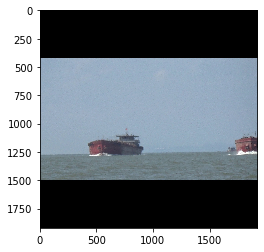

In [12]:
data = './preprocess/246_padding/00001_0_6_1.jpg'
pil_img = Image.open(data, 'r')
plt.imshow(np.asarray(pil_img))

In [13]:
!ls ./data/246/246_img/ | wc -l

6477


# preparation

In [14]:
# specify image size
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

# Metric (Quadratic Weighted Kappa)

In [15]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    
    :param model: A Keras model object
    :param generator: A Keras ImageDataGenerator object
    
    :return: A tuple with two Numpy Arrays. One containing the predictions
    and one containing the labels
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [16]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        
        :param epoch: The current epoch number
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, valid_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(1, 5)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

# EDA (Exploratory Data Analysis)

Text(0.5, 0, 'Frequency')

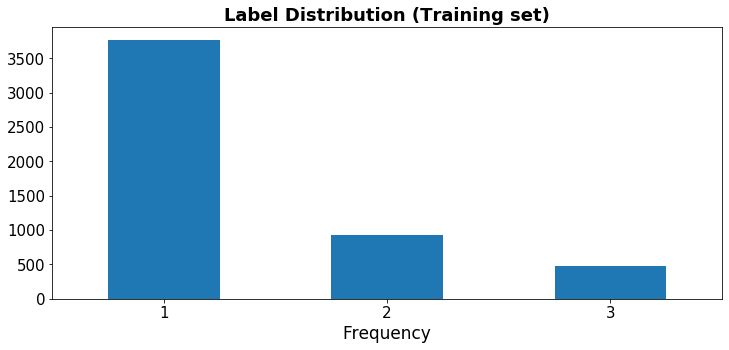

In [17]:
# label distribution
train_df['category'].value_counts().sort_index().plot(kind='bar',
                                                     figsize=(12,5),
                                                      rot=0)

plt.title("Label Distribution (Training set)",
        weight='bold',
        fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.xlabel("Frequency", fontsize=17)

Text(0.5, 0, 'Frequency')

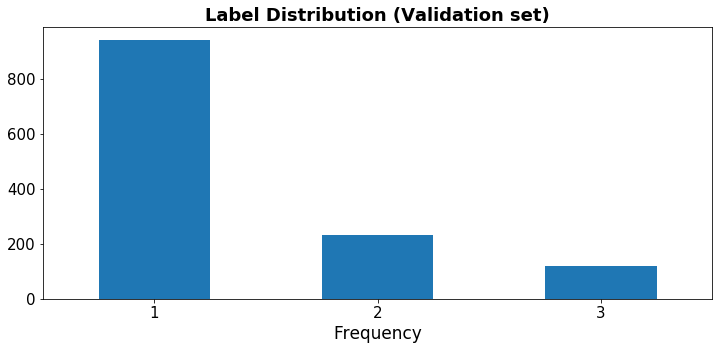

In [20]:
# label distribution
valid_df['category'].value_counts().sort_index().plot(kind='bar',
                                                     figsize=(12,5),
                                                      rot=0)

plt.title("Label Distribution (Validation set)",
        weight='bold',
        fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.xlabel("Frequency", fontsize=17)

(3768, 3)
(933, 3)
(479, 3)


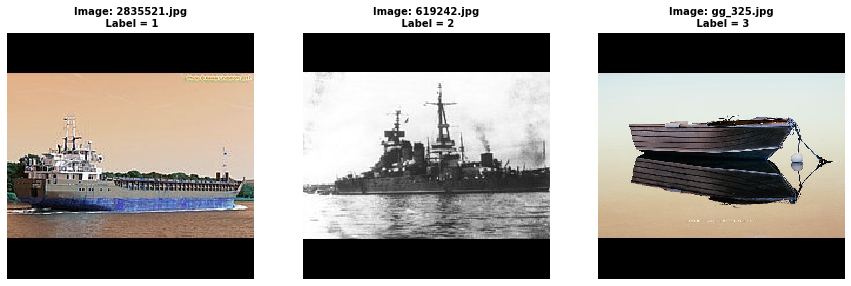

In [19]:
# Example from every label
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
for i in range(0,3):
    print(train_df[train_df['category'] == i+1].shape)
    sample = train_df[train_df['category'] == i+1].sample(1)
    image_name = sample['image'].item()
    X = cv2.imread(f"{train_image_path}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['category'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

# Preprocessing

In [21]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

In [22]:
y_labels = train_df['category'].values

# Modeling

In [23]:
class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
            
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs
    
    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [24]:
# modeling
BATCH_SIZE = 2

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=preprocess_image, 
                                   rescale=1 / 128.)

# train_datagen = ImageDataGenerator(width_shift_range=0.2,
#                                    height_shift_range=0.2,
# #                                    fill_mode='nearest',
#                                    rotation_range=20,
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    preprocessing_function=preprocess_image,
#                                    rescale=1 / 128.)

# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='image', 
                                                    y_col='category',
                                                    directory = train_image_path,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='raw')

valid_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.15,
                                   preprocessing_function=preprocess_image, 
                                   rescale=1 / 128.)

valid_generator = valid_datagen.flow_from_dataframe(valid_df, 
                                                  x_col='image', 
                                                  y_col='category',
                                                  directory = valid_image_path,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='raw')


Found 5180 validated image filenames.
Found 1297 validated image filenames.


In [25]:
# Load in EfficientNetB5
effnet = EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
effnet.load_weights('./weight/efficientnet-b5_imagenet_1000_notop.h5')
effnet.summary()

Model: "efficientnet-b5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 456, 456, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 228, 228, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 228, 228, 48) 0           stem_bn[0][0]                    
____________________________________________________________________________________

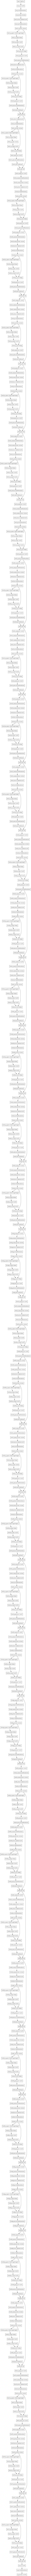

In [26]:
tf.keras.utils.plot_model(
    effnet, to_file='effnet.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=100)

In [ ]:
# # Replace all Batch Normalization layers by Group Normalization layers
# for i, layer in enumerate(effnet.layers):
#      if "batch_normalization" in layer.name:
#         effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

In [27]:
# from keras_radam import RAdam
def build_model():
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='elu'))  
    model.add(Dense(1, activation='linear'))  
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=0.00005), 
#                   optimizer='rmsprop',
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

# Initialize model
model = build_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 28,519,671
Trainable params: 28,346,935
Non-trainable params: 172,736
_________________________________________________________________
None


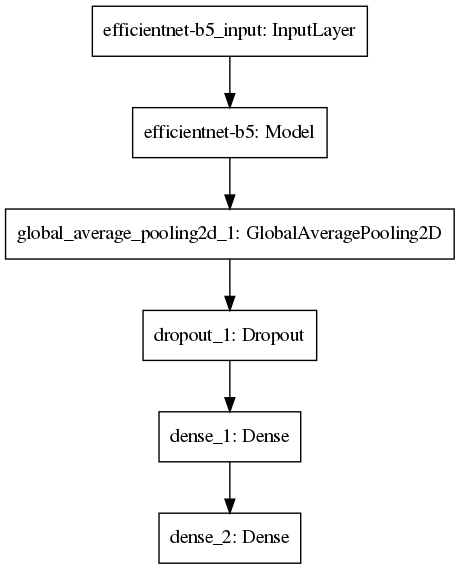

In [32]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=100)

In [33]:
# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()
# Monitor MSE to avoid overfitting and save best model
es = EarlyStopping(monitor='val_loss', 
                   mode='auto', 
                   verbose=1, 
                   patience=12)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4,
                        verbose=1, 
                        mode='auto', 
                        epsilon=0.0001)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [34]:
# Begin training
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=60,
                    validation_data=valid_generator,
                    validation_steps = valid_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, es, rlr])

Epoch 1/60
2590/2590 [==============================] - 1794s 693ms/step - loss: 0.3561 - mse: 0.3561 - acc: 0.6459 - val_loss: 0.4221 - val_mse: 0.1999 - val_acc: 0.8032
val_kappa: 0.678
Validation Kappa has improved. Saving model.
Epoch 2/60
2590/2590 [==============================] - 1768s 682ms/step - loss: 0.2298 - mse: 0.2298 - acc: 0.7334 - val_loss: 0.3691 - val_mse: 0.3503 - val_acc: 0.5328
val_kappa: 0.5747
Epoch 3/60
2590/2590 [==============================] - 1744s 673ms/step - loss: 0.1590 - mse: 0.1590 - acc: 0.8166 - val_loss: 0.1030 - val_mse: 0.1590 - val_acc: 0.8255
val_kappa: 0.7792
Validation Kappa has improved. Saving model.
Epoch 4/60
2590/2590 [==============================] - 1737s 671ms/step - loss: 0.1270 - mse: 0.1270 - acc: 0.8610 - val_loss: 0.0472 - val_mse: 0.1745 - val_acc: 0.8008
val_kappa: 0.8242
Validation Kappa has improved. Saving model.
Epoch 5/60
2590/2590 [==============================] - 1731s 668ms/step - loss: 0.1063 - mse: 0.1063 - acc: 0

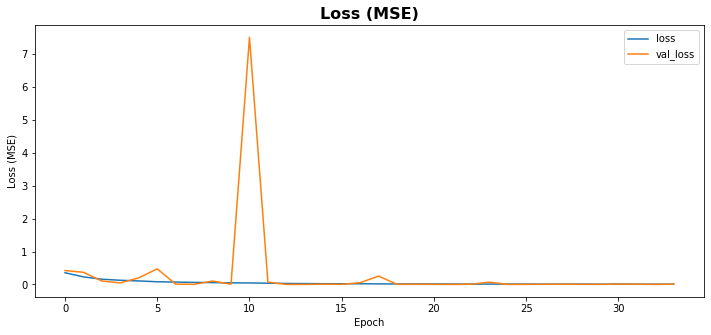

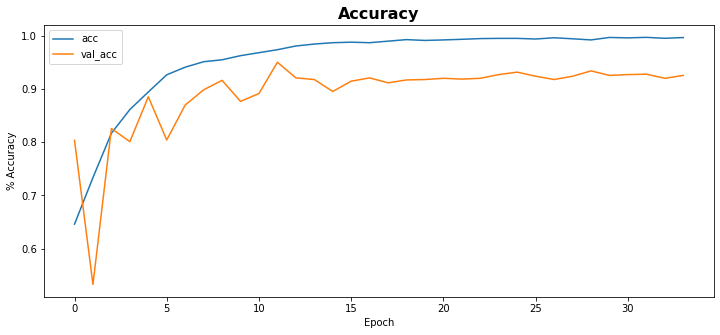

In [35]:
# Visualize mse
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

# Evaluation

In [36]:
# Load best weights according to MSE
model.load_weights(SAVED_MODEL_NAME)

In [37]:
# Calculate QWK on train set
y_train_preds, train_labels = get_preds_and_labels(model, train_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(1, 5)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model, valid_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(1, 5)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

In [38]:
print(f"The Training Cohen Kappa Score is: {round(train_score, 5)}")
print(f"The Validation Cohen Kappa Score is: {round(val_score, 5)}")

The Training Cohen Kappa Score is: 0.91843
The Validation Cohen Kappa Score is: 0.90464


In [39]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            else:
                X_p[i] = 3

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            else:
                X_p[i] = 3
        return X_p

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [40]:
import scipy as sp

# Optimize on validation data and evaluate again
y_val_preds, val_labels = get_preds_and_labels(model, valid_generator)
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients = optR.coefficients()
opt_val_predictions = optR.predict(y_val_preds, coefficients)
new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")

In [41]:
print(f"Optimized Thresholds:\n{coefficients}\n")
print(f"The Validation Quadratic Weighted Kappa (QWK)\n\with optimized rounding thresholds is: {round(new_val_score, 5)}\n")
print(f"This is an improvement of {round(new_val_score - val_score, 5)}\n\over the unoptimized rounding")

Optimized Thresholds:
[0.4734375 1.6265625 2.359375  3.4671875]

The Validation Quadratic Weighted Kappa (QWK)
\with optimized rounding thresholds is: 0.98049

This is an improvement of 0.07585
\over the unoptimized rounding


In [42]:
test_df['category'] = np.zeros(test_df.shape[0]) 
# For preprocessing test images
test_generator = ImageDataGenerator(preprocessing_function=preprocess_image, 
                                    rescale=1 / 128.).flow_from_dataframe(test_df, 
                                                                          x_col='image', 
                                                                          y_col='category',
                                                                          directory=test_image_path,
                                                                          target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                          batch_size=BATCH_SIZE,
                                                                          class_mode='raw',
                                                                          shuffle=False)

Found 2680 validated image filenames.


In [43]:
y_test, _ = get_preds_and_labels(model, test_generator)
y_test = optR.predict(y_test, coefficients).astype(np.uint8)
test_df['category'] = y_test
# Remove .jpg from ids
test_df.to_csv('submission.csv', index=False)

In [44]:
# Check submission
print("Submission File")
display(test_df.head())

Submission File


,image,category
0,1007700.jpg,3
1,1011369.jpg,3
2,1051155.jpg,3
3,1062001.jpg,2
4,1069397.jpg,2


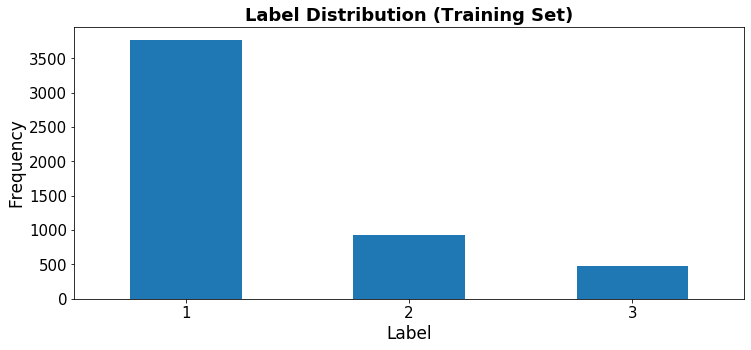

In [45]:
# Label distribution
train_df['category'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

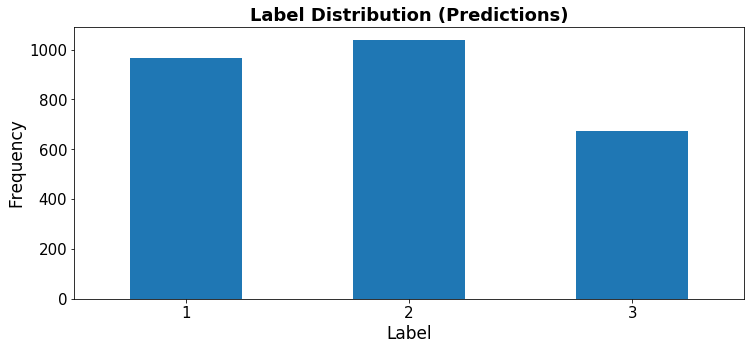

In [46]:
# Distribution of predictions
test_df['category'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)
plt.title("Label Distribution (Predictions)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

# Time consuming

In [47]:
# Check kernels run-time. GPU limit for this competition is set to ± 9 hours.
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, int(total_time*60)))

Kernel runtime = 18.7947 hours (1127 minutes)


# Confusion matrix

In [48]:
# print('y_val_preds\n', opt_val_predictions)
# print('val_labels\n', val_labels)

[[938   5   0]
 [ 15 219   0]
 [  0   1 119]]


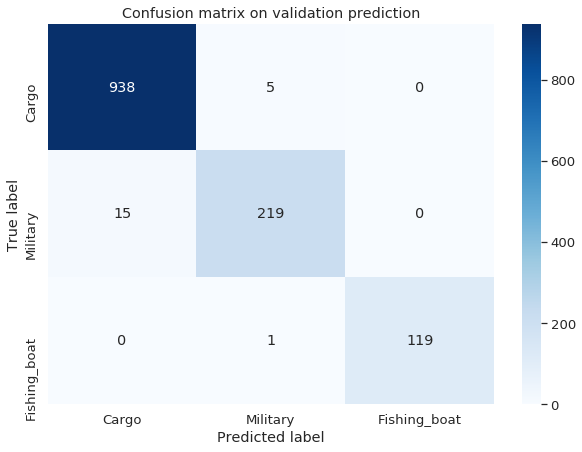

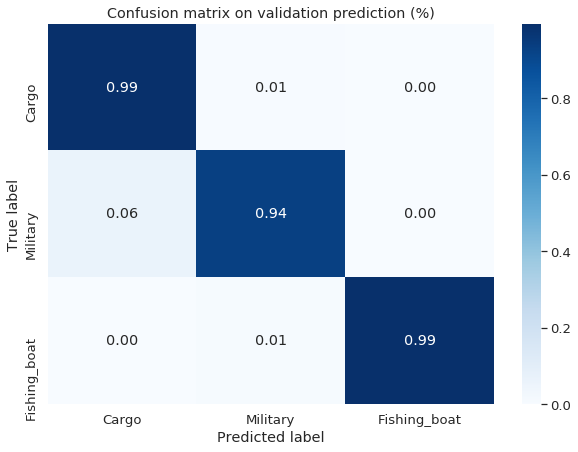

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn

cm = confusion_matrix(y_true = val_labels, y_pred = opt_val_predictions)
print(cm)

cm_df = pd.DataFrame(cm,
                     index = ['Cargo','Military', 'Fishing_boat'], 
                     columns = ['Cargo','Military', 'Fishing_boat'])
plt.figure(figsize=(10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm_df, annot=True, fmt='d', cmap = "Blues")
plt.title('Confusion matrix on validation prediction')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Normalize
normalize_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
normalize_cm = pd.DataFrame(normalize_cm,
                     index = ['Cargo','Military', 'Fishing_boat'], 
                     columns = ['Cargo','Military', 'Fishing_boat'])
plt.figure(figsize=(10,7))
sn.set(font_scale=1.2)
sn.heatmap(normalize_cm, annot=True, fmt='.2f', cmap = "Blues")
plt.title('Confusion matrix on validation prediction (%)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# calculate inference time

In [ ]:
from keras.models import load_model

In [ ]:
new_model = load_model('/media/veec20/Data/duongdq/CNN/gameofdeeplearning/weight/176/176_efficient_model.h5')
new_model.summary()                           